<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
# import AlbTrainTransforms
import LR_Finder as lrf

displayData-1.11 loaded ...


  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [5]:
from albumentations import Compose, RandomCrop, Normalize, Resize, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip
from albumentations.pytorch import ToTensor
import numpy as np


class train_transforms():
  """
  Transformations Applied:-

  1. PadIfNeeded: To pad the image by 4 pixels on each side, making the input image size = 40x40
  2. RandomCrop: To crop out 32x32 portion of the input image(40x400)
  3. Flip: Flip the input image horizontally or vertically at p = 0.50
  4. Cutout: Blocking a 8x8 portion of the input image at p = 1.0
  5. Normalize: Simply the normalizing the transformed image
  6. ToTensor: Converting the normalized image to Tensor
  """

  def __init__(self):
        self.albTrainTransforms = Compose([ 
            PadIfNeeded(min_height = 36, min_width = 36, border_mode = 0, p = 1.0),
            RandomCrop(height = 32, width = 32, p = 1.0),
            Flip(p=0.5),
            Cutout(num_holes = 1, max_h_size = 8, max_w_size = 8, p = 1.0),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensor()
        ])

        print("REQUIRED LIBRARIES LOADED...")

  def __call__(self, img):
        img = np.array(img)
        img = self.albTrainTransforms(image=img)['image']
        return img

albTrain = train_transforms()
albTest = AlbTestTransforms.test_transforms()

REQUIRED LIBRARIES LOADED...
AlbTestTransforms-1.11 loaded ...


**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [7]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


DataLoaders-1.11 loaded ...


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

In [9]:
display.classimages(trainLoader)


AttributeError: ignored

**CustomNet**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic Block

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        # Residual Block
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                                stride = stride, padding = 1, bias = False)
        self.bn1 = nn.Sequential(nn.BatchNorm2d(planes), nn.ReLU())
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                                stride = stride, padding = 1, bias=False)
        self.bn2 = nn.Sequential(nn.BatchNorm2d(planes), nn.ReLU())

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=3,padding=1, bias=False),
                nn.BatchNorm2d(self.expansion*planes))
                # nn.MaxPool2d((2,2)))
            # self.shortcut = nn.Sequential(nn.MaxPool2d((2,2)))
          
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # print("shape of out x", out.shape)
        # print("shape of shortcut x", self.shortcut(x).shape)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

# customNet Class
class customNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(customNet,self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False))
        self.bn1 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU())
                            
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.pool1 = nn.MaxPool2d((2,2))
        self.bn2 = nn.Sequential(nn.BatchNorm2d(128), nn.ReLU())

        self.res1 = self._make_layer(block, 128, num_blocks[0], stride = 1) # I have assigned num_blocks to 2
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride =1, padding = 1, bias = False)
        self.pool2 = nn.MaxPool2d((2,2))
        self.bn3 = nn.Sequential(nn.BatchNorm2d(256), nn.ReLU())

        self.conv4 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.pool3 = nn.MaxPool2d((2,2))
        self.bn4 = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU())

        self.in_planes = 512
        self.res2 = self._make_layer(block, 512, num_blocks[1], stride = 1)
        
        self.pool4 = nn.MaxPool2d((4,4))
        self.linear = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        # print('strides', strides)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
            # print('self.in_planes', self.in_planes)
        # print("layers", layers)
        return nn.Sequential(*layers)

    
    def forward(self, x):

        """
        Function Variables:
        l1X: X at Layer 1
        l2X: X at Layer 2
        """
        l1X = self.conv1(x)
        l1X = self.bn1(l1X)
        l1X = self.conv2(l1X)
        l1X = self.pool1(l1X)
        l1X = self.bn2(l1X)
        # print("l1X shape", l1X.shape)
       

        res1 = self.res1(l1X)
        # print("res1 shape", res1.shape)
        res1X = res1 + l1X
        

        l2X = self.conv3(res1X)
        l2X = self.pool2(l2X)
        l2X = self.bn3(l2X)

        l3X = self.conv4(l2X)
        l3X = self.pool3(l3X)
        l3X = self.bn4(l3X)

        res2 = self.res2(l3X)
        res2X = res2 + l3X

        outX = self.pool4(res2X)
        outX = outX.view(outX.size(0), -1)
        outX = self.linear(outX)

        return outX


def main11():
  return customNet(BasicBlock, [2,2])





In [19]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-1

**LR Finder**

In [20]:
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

The loss has diverged, Stopping Early!


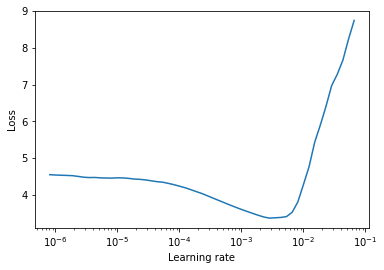

In [21]:
lr_finder.plot()# best lr is in b/w 0.009 and 0.1

In [0]:
lr_finder.reset()

**Modelling**

In [28]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = main11().to(device)

criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, weight_decay=1e-4, nesterov = True) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', threshold_mode = "abs", patience=2, factor = 0.9, verbose=True)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 3


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = param_group['lr'], e=epoch+1))

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.6337428092956543 Batch_id=97 Accuracy=34.03: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.6196).  Saving model ...

Test set: Average loss: 1.6196, Accuracy: 4345/10000 (43.45%)

Learning Rate = 0.001 for EPOCH 2
EPOCH:  2


Loss=2.291888952255249 Batch_id=97 Accuracy=48.82: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.6196 --> 1.2477).  Saving model ...

Test set: Average loss: 1.2477, Accuracy: 5495/10000 (54.95%)

Learning Rate = 0.001 for EPOCH 3
EPOCH:  3


Loss=2.142422676086426 Batch_id=97 Accuracy=54.79: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]


Validation loss has  decreased (1.2477 --> 1.1060).  Saving model ...

Test set: Average loss: 1.1060, Accuracy: 5832/10000 (58.32%)

Learning Rate = 0.001 for EPOCH 4


**Plot Train & Test Curves**

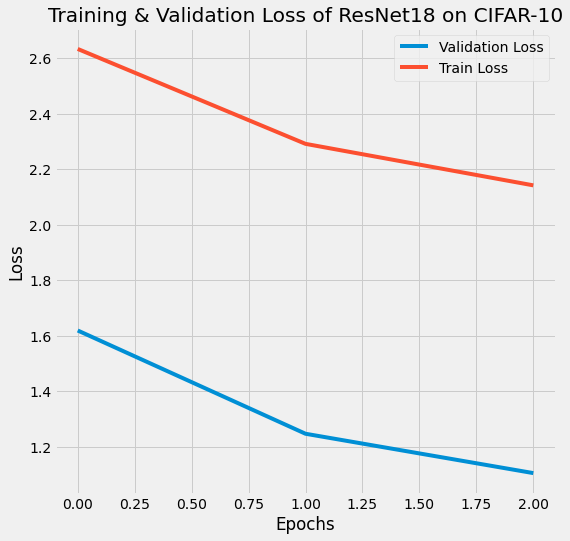

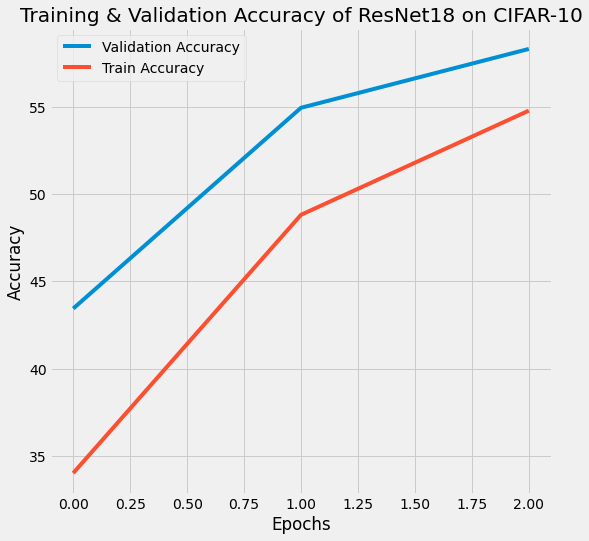

In [29]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Misclassified Images**

In [0]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


In [0]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM():
    """ Helper Class for extracting activations and
    registering gradients from target(intermediate) layers
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output): # this will return Input & Output of  a layer during Forward Pass
              self.fmap_pool[key] = output.detach() #

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out): # this will return Input & Output of a layer during Backward Pass
              self.grad_pool[key] = grad_out[0].detach() #

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name))) # appending I/P & O/P of a layer during forward pass
                self.handlers.append(module.register_backward_hook(save_grads(name))) # same during backward pass

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)  # creating a one hot tensor of self.nll shape, but filled with zeros
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0) # replacing ids with 1.0 at dim = 1
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam





def GRADCAM(images, device, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(device)
  # set up grad cam
  gcam = GradCAM(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids



def PLOT(gcam_layers, images, target_layers, image_size, unnormalize, tc, pc):
    """
    ***Arguments***:
    gcam_layers:
    images: set of images(both correctly classified and misclassified)
    target_layers: set of layers where you want to plot GradCAM
    image_size: size of image
    unnormalize: de/unnormalizing the image
    tc: actual/target class labels
    pc: predicted class labels
    """

    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(30,32))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=12)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=12)
      plt.axis('off')
      

      for j in range(len(images)):
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f'pred={pc[j]}\nactual={tc[j]}', fontsize=10)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')


        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')

        plt.axis('off')
    plt.show()


**GradCam Core** 

IMPLEMENTING GRADCAM FOR SET1[...]
torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


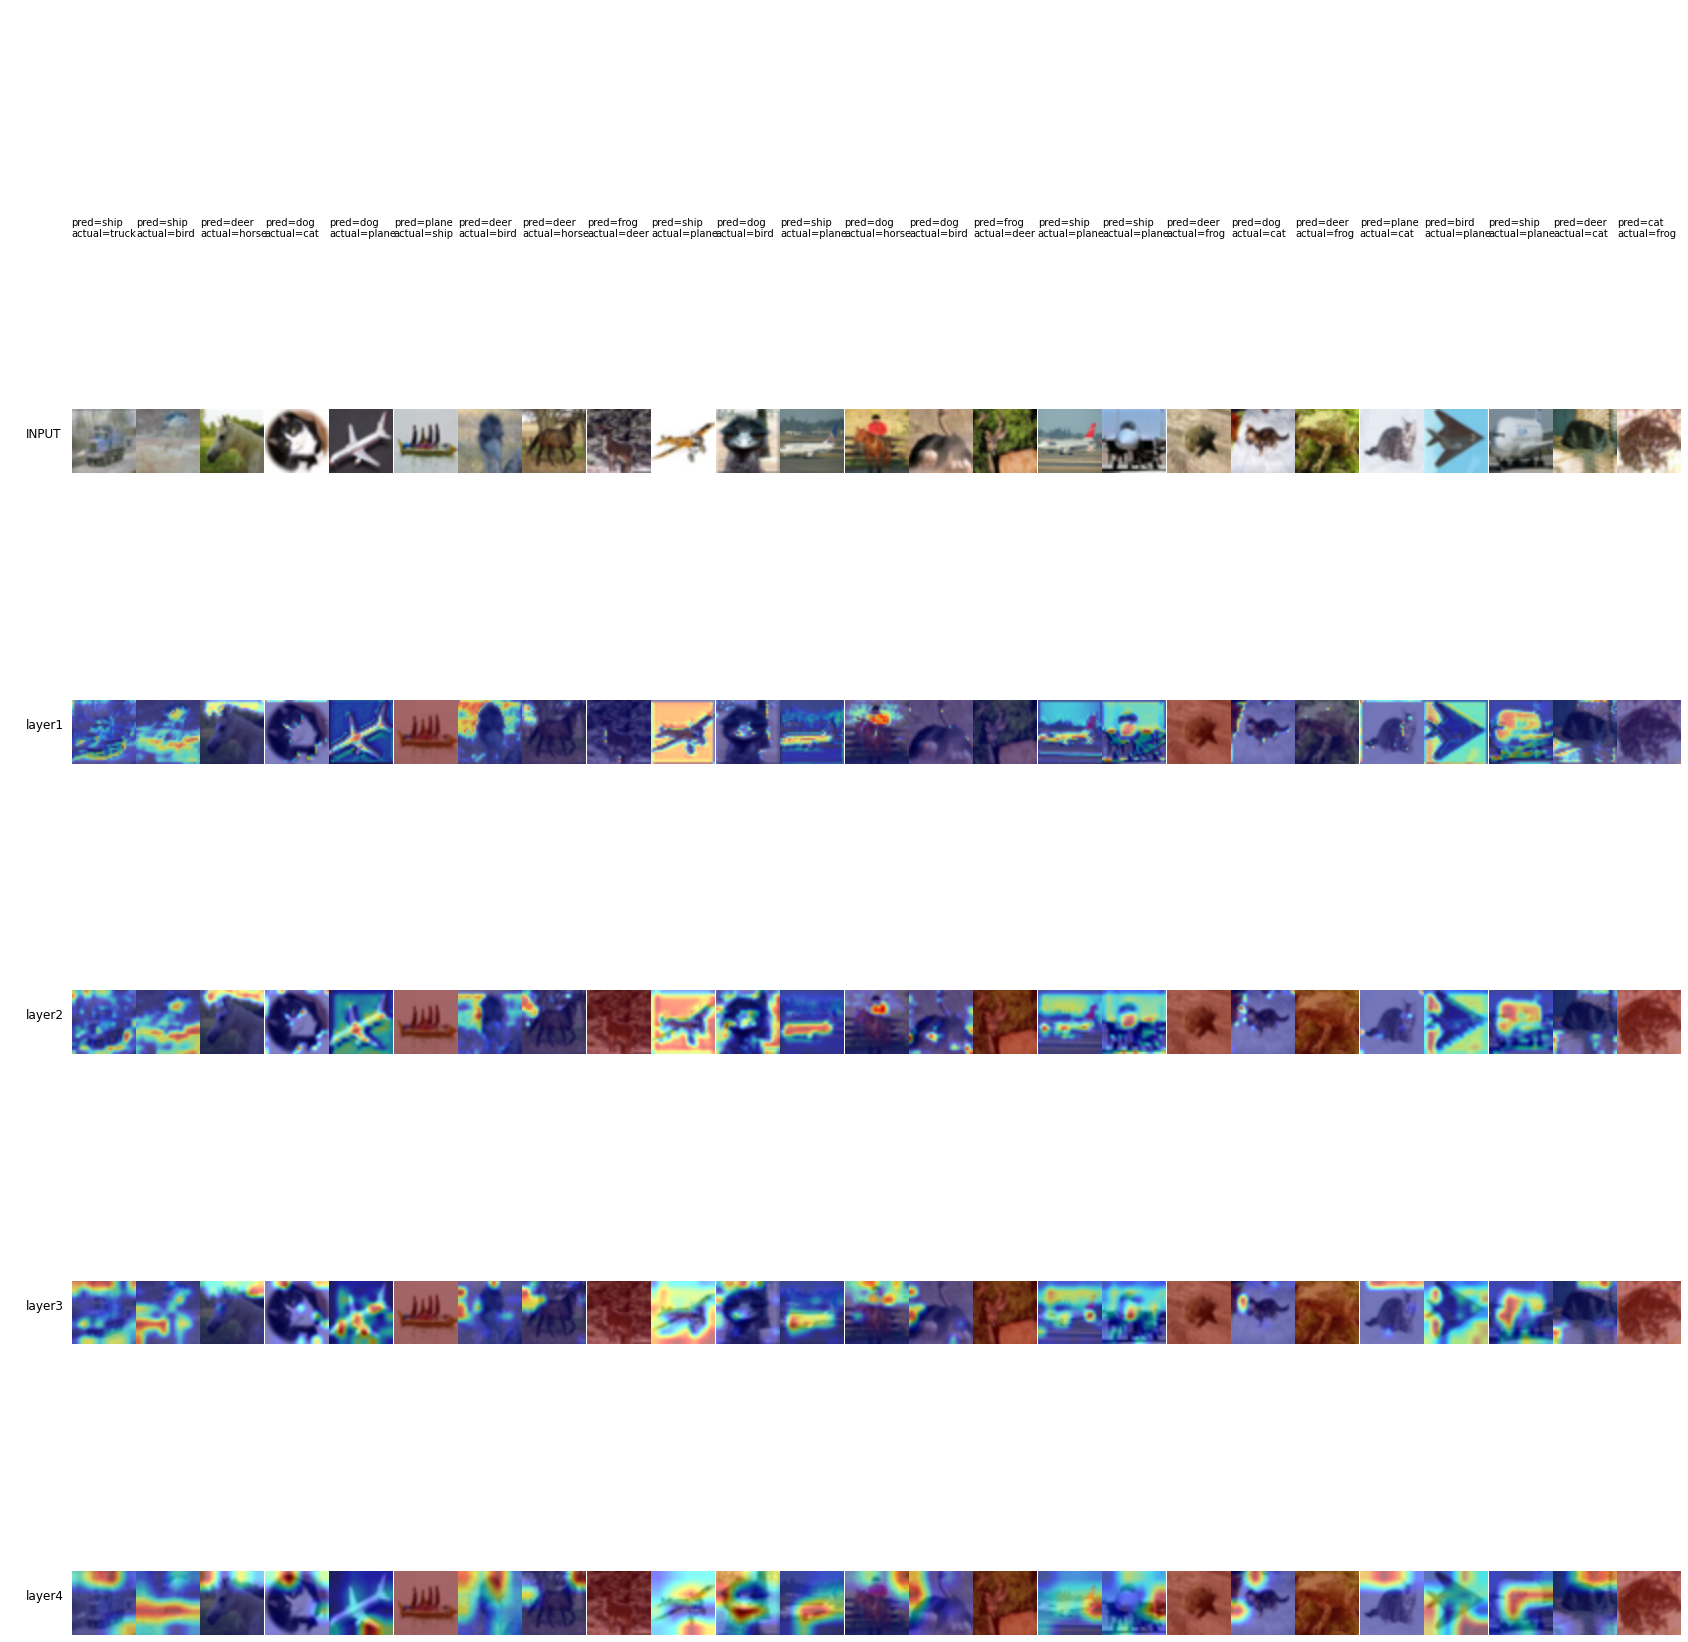

In [32]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET1[...]')
gradcam_output, probs, predicted_classes = GRADCAM(images, device, target_classes, model, target_layers) 
#gdc.
PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
